Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)           │ (None, 128, 128, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ghost_module_14 (GhostModule)        │ (None, 64, 64, 16)          │             152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ghost_bottleneck_6 (GhostBottleneck) │ (None, 32, 32, 32)          │           2,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ghost_bottleneck_7 (GhostBottleneck) │ (None, 16, 16, 64)          │          10,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ghost_bottleneck_8 (GhostBottleneck) │ (None, 8, 8, 128)           │          38,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_11          │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 68,369 (267.07 KB)

 Trainable params: 68,369 (267.07 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 14s 72ms/step - accuracy: 0.4821 - loss: 0.6973 - val_accuracy: 0.4789 - val_loss: 0.6939
Epoch 2/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - accuracy: 0.5040 - loss: 0.6933 - val_accuracy: 0.5211 - val_loss: 0.6909
Epoch 3/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - accuracy: 0.5193 - loss: 0.6932 - val_accuracy: 0.5298 - val_loss: 0.6904
Epoch 4/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.5334 - loss: 0.6890 - val_accuracy: 0.6565 - val_loss: 0.6085
Epoch 5/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.6547 - loss: 0.6142 - val_accuracy: 0.7263 - val_loss: 0.5055
Epoch 6/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - accuracy: 0.7161 - loss: 0.5567 - val_accuracy: 0.6870 - val_loss: 0.5453
Epoch 7/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - accuracy: 0.7977 - loss: 0.4456 - val_accuracy: 0.9039 - val_loss: 0.2473
Epoch 8/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - accuracy: 0.8780 - loss: 0.3078 - val_accuracy: 0.9592 - 

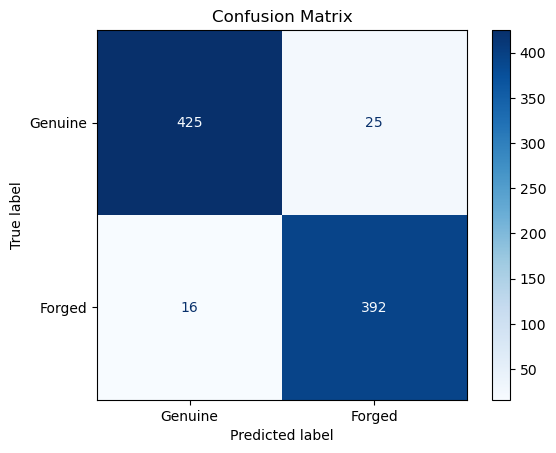

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


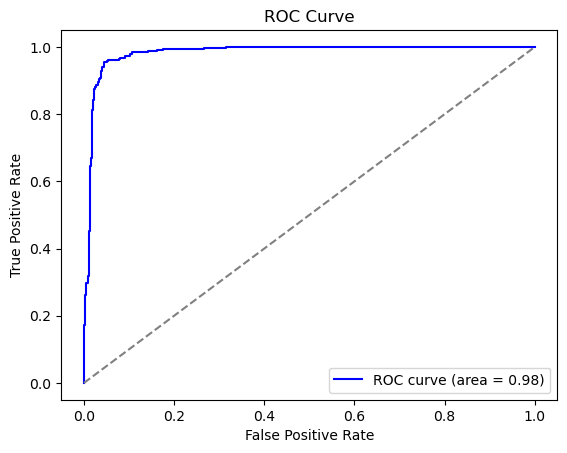

In [3]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Ghost Module
class GhostModule(layers.Layer):
    def __init__(self, filters, kernel_size, strides=1, activation='relu', **kwargs):
        super(GhostModule, self).__init__(**kwargs)
        self.primary_conv = layers.Conv2D(filters // 2, kernel_size, strides=strides, padding='same', activation=activation)
        self.ghost_conv = layers.Conv2D(filters // 2, (1, 1), padding='same', activation=activation)
    
    def call(self, inputs):
        x = self.primary_conv(inputs)
        y = self.ghost_conv(x)
        return layers.concatenate([x, y])

# Ghost Bottleneck
class GhostBottleneck(layers.Layer):
    def __init__(self, filters, strides=1, use_se=False, **kwargs):
        super(GhostBottleneck, self).__init__(**kwargs)
        self.ghost1 = GhostModule(filters, (1, 1))
        self.depthwise = layers.DepthwiseConv2D((3, 3), strides=strides, padding='same')
        self.ghost2 = GhostModule(filters, (1, 1))
        self.use_se = use_se
        if use_se:
            self.se = tf.keras.Sequential([
                layers.GlobalAveragePooling2D(),
                layers.Dense(filters // 4, activation='relu'),
                layers.Dense(filters, activation='sigmoid'),
                layers.Reshape((1, 1, filters))
            ])
        self.shortcut = layers.Conv2D(filters, (1, 1), strides=strides, padding='same') if strides > 1 else lambda x: x
    
    def call(self, inputs):
        x = self.ghost1(inputs)
        x = self.depthwise(x)
        x = self.ghost2(x)
        if self.use_se:
            x = x * self.se(x)
        return x + self.shortcut(inputs)

# Dataset Paths
dataset_paths = {
    'CEDAR': r"D:\signature\CEDAR_relocated",
    'ICDAR': r"D:\signature\ICDAR-2011_relocated"
}

# Load Images Function
def load_images(dataset_path):
    images = []
    labels = []
    for folder in os.listdir(dataset_path):
        folder_path = os.path.join(dataset_path, folder)
        if os.path.isdir(folder_path):
            for label, subfolder in enumerate(['original', 'forged']):
                subfolder_path = os.path.join(folder_path, subfolder)
                if os.path.exists(subfolder_path):
                    for file in os.listdir(subfolder_path):
                        img_path = os.path.join(subfolder_path, file)
                        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                        if img is not None:
                            img = cv2.resize(img, (128, 128))
                            images.append(img)
                            labels.append(label)
    return np.array(images), np.array(labels)

# Load All Datasets
all_images = []
all_labels = []

for dataset_name, dataset_path in dataset_paths.items():
    images, labels = load_images(dataset_path)
    all_images.append(images)
    all_labels.append(labels)

all_images = np.concatenate(all_images, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# Normalize Images
all_images = all_images / 255.0
all_images = all_images.reshape(-1, 128, 128, 1)

# Split Dataset
X_train, X_test, y_train, y_test = train_test_split(all_images, all_labels, test_size=0.2, random_state=42)

# Build GhostNet Model
def build_ghostnet_model():
    inputs = layers.Input(shape=(128, 128, 1))
    x = GhostModule(16, (3, 3), strides=2)(inputs)
    x = GhostBottleneck(32, strides=2, use_se=True)(x)
    x = GhostBottleneck(64, strides=2, use_se=True)(x)
    x = GhostBottleneck(128, strides=2, use_se=True)(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)  # Add dropout after dense layers
    outputs = layers.Dense(1, activation='sigmoid')(x)
    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Train Model
model = build_ghostnet_model()
model.summary()
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

# Evaluate Model
y_pred = (model.predict(X_test) > 0.5).astype(int)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Genuine', 'Forged'])
cmd.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, model.predict(X_test))
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

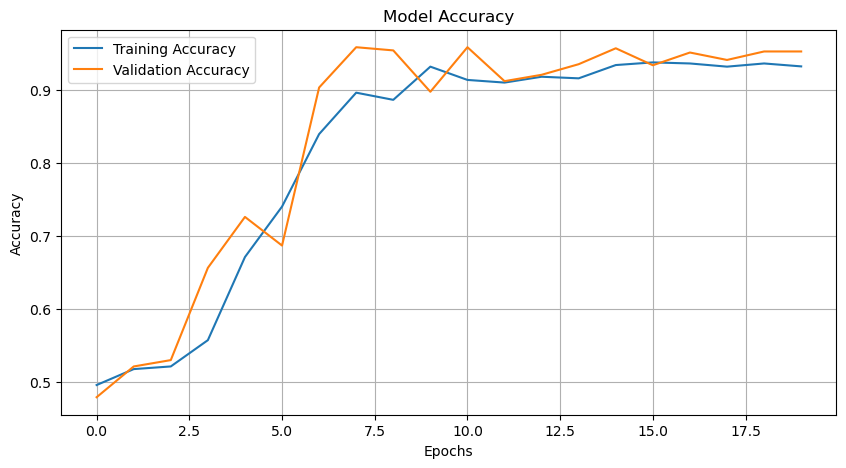

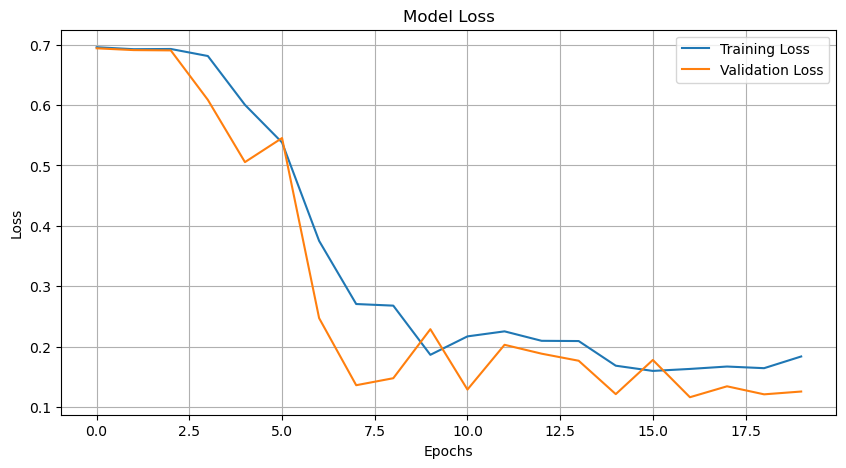

In [18]:
# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


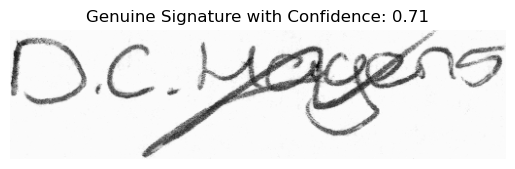

In [19]:
import cv2
import matplotlib.pyplot as plt
# Function to Highlight Forged Areas with Circles
def highlight_forgery(image):
    img = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
    img_resized = cv2.resize(img, (128, 128)) / 255.0
    img_resized = img_resized.reshape(1, 128, 128, 1)
    prediction = model.predict(img_resized)[0][0]

    if prediction > 0.5:
        img_color = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        edges = cv2.Canny(img, 50, 150)  # Edge Detection
        contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        for contour in contours:
            if cv2.contourArea(contour) > 50:  # Filter small noise
                (x, y), radius = cv2.minEnclosingCircle(contour)
                center = (int(x), int(y))
                radius = int(radius)
                cv2.circle(img_color, center, radius, (0, 0, 255), 2)  # Draw red circle

        plt.imshow(cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB))
        plt.title(f"Forgery Detected with Confidence: {prediction:.2f}")
        plt.axis('off')
        plt.show()
    else:
        plt.imshow(img, cmap='gray')
        plt.title(f"Genuine Signature with Confidence: {1-prediction:.2f}")
        plt.axis('off')
        plt.show()

# Example Usage
image_path =  r"D:\signature\ICDAR-2011_relocated\32\Original\01_032.png"# Replace with your image path
highlight_forgery(image_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


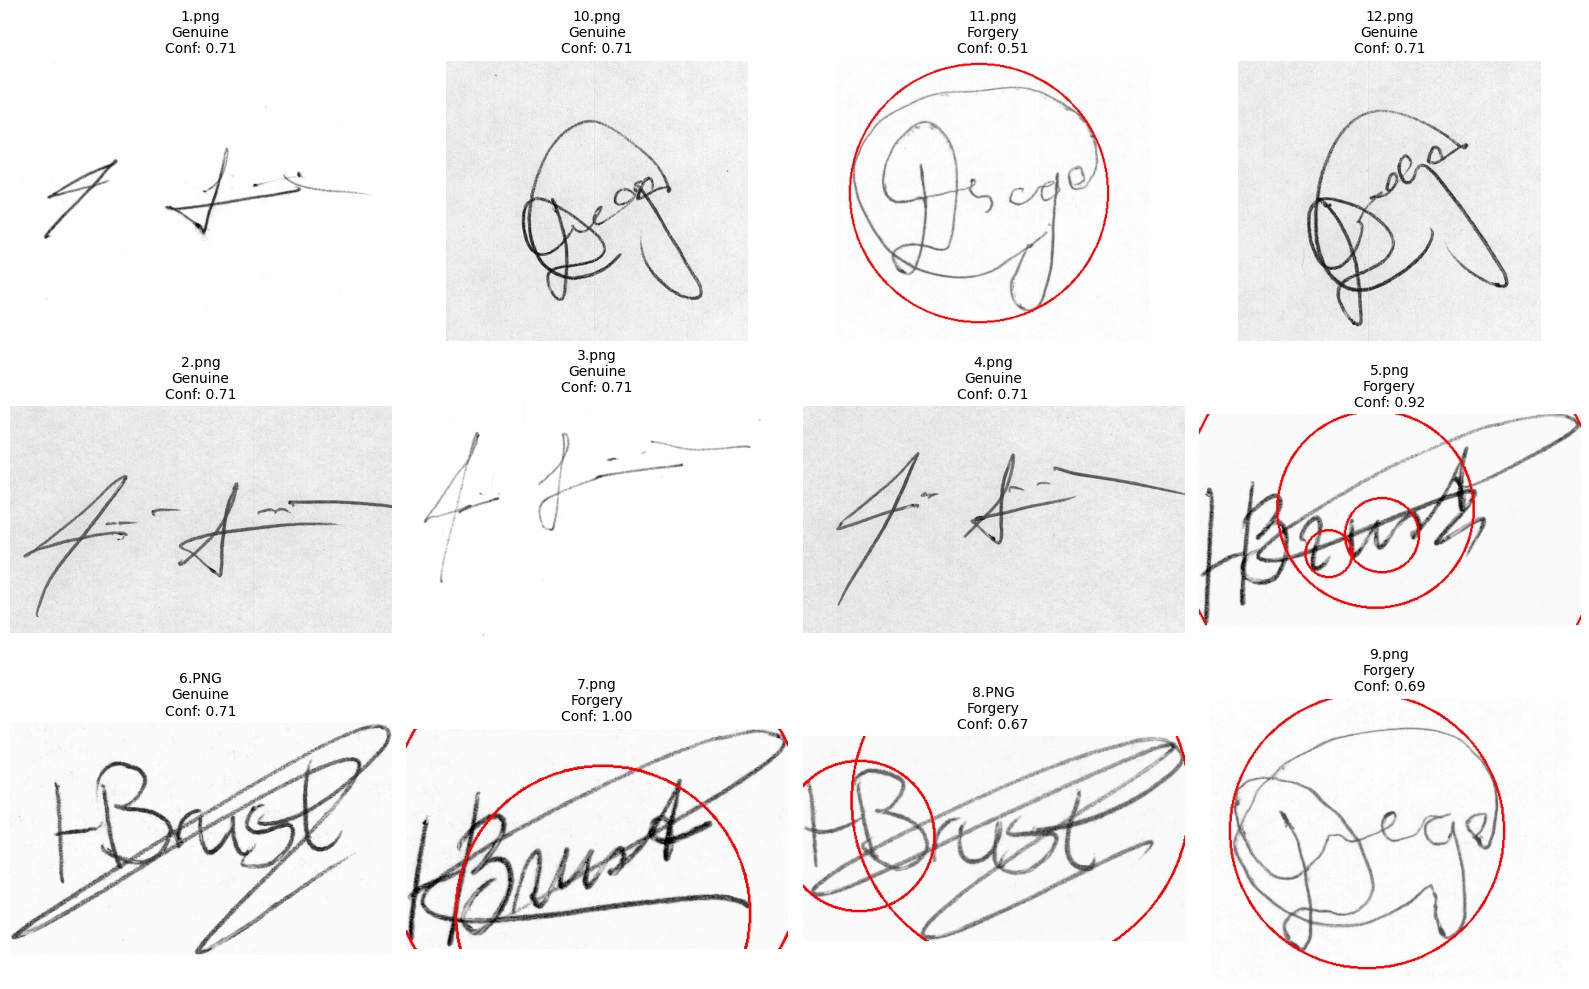

In [21]:
import cv2
import matplotlib.pyplot as plt
import os
import numpy as np

# Function to Highlight Forged Areas with Circles and Return Result
def highlight_forgery_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img_resized = cv2.resize(img, (128, 128)) / 255.0
    img_resized = img_resized.reshape(1, 128, 128, 1)
    prediction = model.predict(img_resized)[0][0]

    if prediction > 0.5:
        img_color = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        edges = cv2.Canny(img, 50, 150)
        contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        for contour in contours:
            if cv2.contourArea(contour) > 50:
                (x, y), radius = cv2.minEnclosingCircle(contour)
                center = (int(x), int(y))
                radius = int(radius)
                cv2.circle(img_color, center, radius, (0, 0, 255), 2)

        final_img = cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB)
        title = f"Forgery\nConf: {prediction:.2f}"
    else:
        final_img = img
        title = f"Genuine\nConf: {1 - prediction:.2f}"

    return final_img, title

# Display Images in 3x4 Grid
def display_grid(folder_path, max_images=12):
    images = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    images = images[:max_images]

    fig, axes = plt.subplots(3, 4, figsize=(16, 10))
    axes = axes.flatten()

    for idx, img_file in enumerate(images):
        image_path = os.path.join(folder_path, img_file)
        result_img, title = highlight_forgery_image(image_path)

        ax = axes[idx]
        if len(result_img.shape) == 2:  # Grayscale
            ax.imshow(result_img, cmap='gray')
        else:  # RGB
            ax.imshow(result_img)

        ax.set_title(f"{img_file}\n{title}", fontsize=10)
        ax.axis('off')

    for i in range(len(images), 12):
        axes[i].axis('off')  # Hide empty subplots

    plt.tight_layout()
    plt.show()

# Example Usage
folder_path = r"D:\signature\test"
display_grid(folder_path)
